# Setup

In [ ]:
!pip install optuna --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
numeric_index = pd.Index([1, 2, 3, 4], dtype='int64')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import optuna
import time
import joblib
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change working directory
os.chdir('/content/drive/MyDrive/PneumoniaCXR-AIDetect')

# Load Data

In [ ]:
# Define Paths
TRAIN_PATH = 'data/interim/ALL_FEATURES/ALL_features_full_train_240331.pkl.gz'
TEST_PATH = 'data/interim/ALL_FEATURES/ALL_features_full_test_240331.pkl.gz'
VAL_PATH = 'data/interim/ALL_FEATURES/ALL_features_full_val_240331.pkl.gz'

In [ ]:
raw_features = pd.read_pickle(TRAIN_PATH)
raw_features_test = pd.read_pickle(TEST_PATH)
raw_features_val = pd.read_pickle(VAL_PATH)

# PCA

In [24]:
# @title Prepare data for PCA
def preprocess_tsne_pca(df):
  """
  Preprocess the dataframe for t-SNE visualization or pca.

  Parameters:
  - df: The dataframe to preprocess.

  Returns:
  - df: The preprocessed dataframe.
  """
  # Make a copy
  df = df.copy()

  # Convert all radiomics columns into a single column
  radiomics_columns = df.columns.difference(['filename', 'diag', 'split', 'hog_features', 'hog_image', 'resnet_embeddings', 'image_normalized', 'image_processed', 'all_features', 'radiomics_features'])
  radiomics_columns_len = len(radiomics_columns.tolist())
  df['radiomics_features'] = df[radiomics_columns].apply(lambda row: np.array(row), axis=1)
  assert df['radiomics_features'].iloc[0].shape == (radiomics_columns_len,)

  # Concatenate hog, radiomics and resnet
  df['all_features'] = df[['hog_features', 'radiomics_features', 'resnet_embeddings']].apply(lambda row: np.concatenate(row), axis=1)
  assert df['all_features'].iloc[0].shape == (df['hog_features'].iloc[0].shape[0] + df['radiomics_features'].iloc[0].shape[0] + df['resnet_embeddings'].iloc[0].shape[0],)

  print(f"Shape of HOG_features: {df['hog_features'].iloc[0].shape}")
  print(f"Shape of Radiomics_features: {df['radiomics_features'].iloc[0].shape}")
  print(f"Shape of Resnet_embeddings: {df['resnet_embeddings'].iloc[0].shape}")
  print(f"Shape of all_features: {df['all_features'].iloc[0].shape}")

  # Only keep relevant columns
  df = df[['diag', 'hog_features', 'radiomics_features', 'resnet_embeddings', 'all_features']]

  return df

df_pca_train = preprocess_tsne_pca(raw_features)
df_pca_test = preprocess_tsne_pca(raw_features_test)
df_pca_val = preprocess_tsne_pca(raw_features_val)

Shape of HOG_features: (13689,)
Shape of Radiomics_features: (241,)
Shape of Resnet_embeddings: (2048,)
Shape of all_features: (15978,)
Shape of HOG_features: (13689,)
Shape of Radiomics_features: (241,)
Shape of Resnet_embeddings: (2048,)
Shape of all_features: (15978,)
Shape of HOG_features: (13689,)
Shape of Radiomics_features: (241,)
Shape of Resnet_embeddings: (2048,)
Shape of all_features: (15978,)


### Fit on training data

In [ ]:
df_pca_train.columns.tolist()

Index(['diag', 'hog_features', 'radiomics_features', 'resnet_embeddings',
       'all_features'],
      dtype='object')

In [ ]:
def apply_pca_to_feature_column(df_train, column_name, n_components=0.95, add_var_thresholds=[0.9, 0.8, 0.7], force_run=True, export_path='data/features_PCA/scaler_pca_objects'):
    """
    Apply PCA to a DataFrame column where each row contains a 1D numpy array, fitting only on the training data.
    Handles multiple variance thresholds to produce transformed data sets for each.

    Args:
        df_train (pd.DataFrame): DataFrame containing the training data.
        column_name (str): Name of the column containing 1D numpy arrays.
        n_components (float or int): Maximum number of components to keep. If float, represents the fraction of variance to keep initially.
        add_var_thresholds (list of float): Optional list of additional variance thresholds for returning multiple PCA-transformed data sets.
        force_run (bool): Whether to force re-running PCA if existing files are found at export_path.
        export_path (str): Path to save or load PCA and Scaler objects.

    Returns:
        dict: Dictionary where keys are variance thresholds (or 'full' for the initial PCA result) and values are the PCA-transformed data sets.
    """
    # Paths for saving/loading objects
    scaler_path = os.path.join(export_path, f"{column_name}_scaler.pkl") if export_path else None
    pca_path = os.path.join(export_path, f"{column_name}_pca.pkl") if export_path else None

    # Prepare data and apply scaling
    data_matrix = np.vstack(df_train[column_name])

    # Check if PCA and scaler need to be loaded from files
    if not force_run and export_path and os.path.exists(scaler_path) and os.path.exists(pca_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        with open(pca_path, 'rb') as f:
            pca = pickle.load(f)
        # Transform data using loaded scaler
        data_scaled = scaler.transform(data_matrix)

    else:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_matrix)

        # Initialize and apply PCA
        pca = PCA(n_components=n_components)
        pca.fit(data_scaled)

        # Optionally save PCA and Scaler
        if export_path:
            os.makedirs(export_path, exist_ok=True)
            with open(scaler_path, 'wb') as f:
                pickle.dump(scaler, f)
            with open(pca_path, 'wb') as f:
                pickle.dump(pca, f)
            print("Saved PCA and Scaler to files.")

    # Transform the full dataset with PCA
    full_data_pca = pca.transform(scaler.transform(data_matrix))
    results = {f'{n_components}': full_data_pca}

    # If specific variance thresholds are provided, create reduced data sets
    if add_var_thresholds:
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        for threshold in add_var_thresholds:
            n_components_needed = np.argmax(cumulative_variance >= threshold) + 1
            results[threshold] = full_data_pca[:, :n_components_needed]

    return results, scaler, pca, pca.explained_variance_ratio_

In [ ]:
# @title Fit for radiomics
radiomics_pca_data_train, radiomics_pca_scaler, radiomics_pca_model, radiomics_pca_variance = apply_pca_to_feature_column(df_pca_train, 'radiomics_features', force_run=True)
_, radiomics_pca_data_train_90, radiomics_pca_data_train_80, radiomics_pca_data_train_70 = radiomics_pca_data_train.values()
print(f"Shapes of 90%, 80% and 70% variance: {radiomics_pca_data_train_90.shape, radiomics_pca_data_train_80.shape, radiomics_pca_data_train_70.shape}")

Saved PCA and Scaler to files.
Shapes of 90%, 80% and 70% variance: ((20547, 22), (20547, 11), (20547, 6))


In [ ]:
# @title Fit for resnet
resnet_pca_data_train, resnet_pca_scaler, resnet_pca_model, resnet_pca_variance = apply_pca_to_feature_column(df_pca_train, 'resnet_embeddings', force_run=True)
_, resnet_pca_data_train_90, resnet_pca_data_train_80, resnet_pca_data_train_70 = resnet_pca_data_train.values()
print(f"Shapes of 90%, 80% and 70% variance: {resnet_pca_data_train_90.shape, resnet_pca_data_train_80.shape, resnet_pca_data_train_70.shape}")

Saved PCA and Scaler to files.
Shapes of 90%, 80% and 70% variance: ((20547, 193), (20547, 84), (20547, 45))


In [ ]:
# @title Fit for HOG
hog_pca_data_train, hog_pca_scaler, hog_pca_model, hog_pca_variance = apply_pca_to_feature_column(df_pca_train, 'hog_features', force_run=True)
_, hog_pca_data_train_90, hog_pca_data_train_80, hog_pca_data_train_70 = hog_pca_data_train.values()
print(f"Shapes of 90%, 80% and 70% variance: {hog_pca_data_train_90.shape, hog_pca_data_train_80.shape, hog_pca_data_train_70.shape}")

Saved PCA and Scaler to files.
Shapes of 90%, 80% and 70% variance: ((20547, 1065), (20547, 607), (20547, 348))


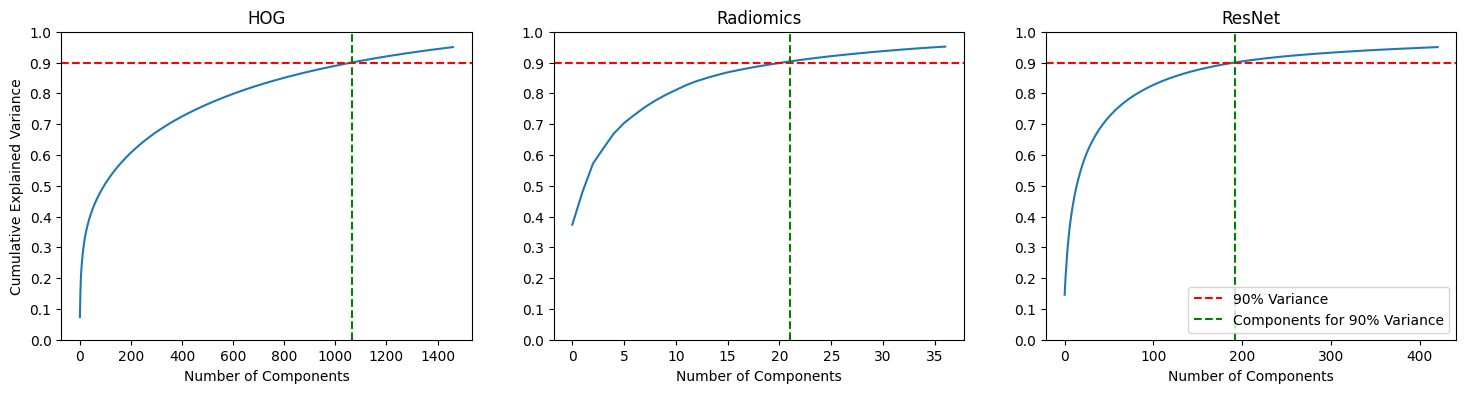

In [ ]:
# @title Vis: PCA Plots
def plot_PCA(pca_objects, feature_sets, var_target=0.9, export_path='reports/figures/PCA_plots.png'):
    """
    Plot the explained variance for PCA objects and mark the component count where the
    cumulative variance exceeds a target threshold.

    Args:
        pca_objects (list): List of PCA model objects.
        feature_sets (list): Corresponding labels for the PCA objects.
        var_target (float): Target cumulative variance threshold.
        export_path (str): Path where the plot will be saved.

    Returns:
        dict: A dictionary mapping feature sets to the number of components needed to exceed var_target.
    """
    if len(pca_objects) != len(feature_sets):
        raise ValueError("The length of pca_objects must match the length of feature_sets")

    component_indices = {}

    # Create a subplot for each PCA result
    fig, axes = plt.subplots(1, len(pca_objects), figsize=(6 * len(pca_objects), 4))
    if len(pca_objects) == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot case

    for i, (pca_obj, feature) in enumerate(zip(pca_objects, feature_sets)):
        # Calculate cumulative variance ratio
        explained_variance_ratio = pca_obj.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

        # Find component index where cumulative variance exceeds the target
        component_count_90 = np.argmax(cumulative_variance_ratio >= var_target)
        component_indices[feature] = component_count_90 + 1  # Adjust for 0-index

        # Plotting
        axes[i].plot(cumulative_variance_ratio, linestyle='-')
        axes[i].set_title(f'{feature}')
        axes[i].set_xlabel('Number of Components')
        axes[i].set_ylim(0, 1)
        axes[i].axhline(y=var_target, color='red', linestyle='--', label=f'{var_target*100:.0f}% Variance')
        axes[i].axvline(x=component_count_90, color='green', linestyle='--', label=f'Components for {var_target*100:.0f}% Variance')

        # Enhancements
        axes[i].yaxis.set_major_locator(MultipleLocator(0.1))

        if i == 0:
            axes[i].set_ylabel('Cumulative Explained Variance')

        if i == 2:
            axes[i].legend(loc='lower right')

    # Save the plot if a path is provided
    if export_path:
        plt.savefig(export_path, bbox_inches='tight')  # Ensure all labels/legends are included

    plt.show()

    return component_indices

component_indices = plot_PCA([hog_pca_model, radiomics_pca_model, resnet_pca_model], ['HOG', 'Radiomics', 'ResNet'])

### Apply to Test and Val Data

In [ ]:
df_pca_test = preprocess_tsne_pca(df_features_test)
df_pca_val = preprocess_tsne_pca(df_features_val)

Shape of HOG_features: (13689,)
Shape of Radiomics_features: (241,)
Shape of Resnet_embeddings: (2048,)
Shape of all_features: (15978,)
Shape of HOG_features: (13689,)
Shape of Radiomics_features: (241,)
Shape of Resnet_embeddings: (2048,)
Shape of all_features: (15978,)


In [ ]:
def transform_val_test_data(df, column_name, scaler, pca, variance_thresholds):
    """
    Transform test data using the already fitted scaler and PCA for multiple variance thresholds.

    Args:
        df (pd.DataFrame): DataFrame containing the test data.
        column_name (str): Name of the column to be transformed.
        scaler (StandardScaler): Fitted scaler object.
        pca (PCA): Fitted PCA object.
        variance_thresholds (list of float): List of variance thresholds for data transformation.

    Returns:
        dict: Dictionary where keys are variance thresholds and values are the PCA-transformed test data.
    """
    data_matrix = np.vstack(df[column_name])
    data_scaled = scaler.transform(data_matrix)
    full_data_pca = pca.transform(data_scaled)

    results = {}
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    for threshold in variance_thresholds:
        n_components_needed = np.argmax(cumulative_variance >= threshold) + 1
        results[threshold] = full_data_pca[:, :n_components_needed]

    return results

In [ ]:
hog_pca_data_test = transform_val_test_data(df_pca_test, 'hog_features', hog_pca_scaler, hog_pca_model, [0.9, 0.8, 0.7])
radiomics_pca_data_test = transform_val_test_data(df_pca_test, 'radiomics_features', radiomics_pca_scaler, radiomics_pca_model, [0.9, 0.8, 0.7])
resnet_pca_data_test = transform_val_test_data(df_pca_test, 'resnet_embeddings', resnet_pca_scaler, resnet_pca_model, [0.9, 0.8, 0.7])

In [ ]:
hog_pca_data_val = transform_val_test_data(df_pca_val, 'hog_features', hog_pca_scaler, hog_pca_model, [0.9, 0.8, 0.7])
radiomics_pca_data_val = transform_val_test_data(df_pca_val, 'radiomics_features', radiomics_pca_scaler, radiomics_pca_model, [0.9, 0.8, 0.7])
resnet_pca_data_val = transform_val_test_data(df_pca_val, 'resnet_embeddings', resnet_pca_scaler, resnet_pca_model, [0.9, 0.8, 0.7])

### Export as Pickle Files

In [ ]:
# @title Concatenate feature sets
X_train_PCA_90 = np.hstack([hog_pca_data_train[0.9], radiomics_pca_data_train[0.9], resnet_pca_data_train[0.9]])
X_test_PCA_90 = np.hstack([hog_pca_data_test[0.9], radiomics_pca_data_test[0.9], resnet_pca_data_test[0.9]])
X_val_PCA_90 = np.hstack([hog_pca_data_val[0.9], radiomics_pca_data_val[0.9], resnet_pca_data_val[0.9]])

print(f"Shape of X_train_PCA_90: {X_train_PCA_90.shape}")
print(f"Shape of X_test_PCA_90: {X_test_PCA_90.shape}")
print(f"Shape of X_val_PCA_90: {X_val_PCA_90.shape}")

assert X_train_PCA_90.shape[1] == X_test_PCA_90.shape[1] == X_val_PCA_90.shape[1]

X_train_PCA_80 = np.hstack([hog_pca_data_train[0.8], radiomics_pca_data_train[0.8], resnet_pca_data_train[0.8]])
X_test_PCA_80 = np.hstack([hog_pca_data_test[0.8], radiomics_pca_data_test[0.8], resnet_pca_data_test[0.8]])
X_val_PCA_80 = np.hstack([hog_pca_data_val[0.8], radiomics_pca_data_val[0.8], resnet_pca_data_val[0.8]])

print(f"Shape of X_train_PCA_80: {X_train_PCA_80.shape}")
print(f"Shape of X_test_PCA_80: {X_test_PCA_80.shape}")
print(f"Shape of X_val_PCA_80: {X_val_PCA_80.shape}")

assert X_train_PCA_80.shape[1] == X_test_PCA_80.shape[1] == X_val_PCA_80.shape[1]

X_train_PCA_70 = np.hstack([hog_pca_data_train[0.7], radiomics_pca_data_train[0.7], resnet_pca_data_train[0.7]])
X_test_PCA_70 = np.hstack([hog_pca_data_test[0.7], radiomics_pca_data_test[0.7], resnet_pca_data_test[0.7]])
X_val_PCA_70 = np.hstack([hog_pca_data_val[0.7], radiomics_pca_data_val[0.7], resnet_pca_data_val[0.7]])

print(f"Shape of X_train_PCA_70: {X_train_PCA_70.shape}")
print(f"Shape of X_test_PCA_70: {X_test_PCA_70.shape}")
print(f"Shape of X_val_PCA_70: {X_val_PCA_70.shape}")

assert X_train_PCA_70.shape[1] == X_test_PCA_70.shape[1] == X_val_PCA_70.shape[1]

y_train = df_pca_train['diag']
y_test = df_pca_test['diag']
y_val = df_pca_val['diag']

print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of X_train_PCA_90: (20547, 1280)
Shape of X_test_PCA_90: (6420, 1280)
Shape of X_val_PCA_90: (5136, 1280)
Shape of X_train_PCA_80: (20547, 702)
Shape of X_test_PCA_80: (6420, 702)
Shape of X_val_PCA_80: (5136, 702)
Shape of X_train_PCA_70: (20547, 399)
Shape of X_test_PCA_70: (6420, 399)
Shape of X_val_PCA_70: (5136, 399)
Shape of y_train: (20547,)
Shape of y_test: (6420,)
Shape of y_val: (5136,)


In [ ]:
# @title Export
var_names = [
    X_train_PCA_90,
    X_train_PCA_80,
    X_train_PCA_70,
    X_test_PCA_90,
    X_test_PCA_80,
    X_test_PCA_70,
    X_val_PCA_90,
    X_val_PCA_80,
    X_val_PCA_70,
    y_train,
    y_train,
    y_train,
    y_test,
    y_test,
    y_test,
    y_val,
    y_val,
    y_val
]

file_names = [
    'X_train_feature_reduction_90.pickle',
    'X_train_feature_reduction_80.pickle',
    'X_train_feature_reduction_70.pickle',
    'X_test_feature_reduction_90.pickle',
    'X_test_feature_reduction_80.pickle',
    'X_test_feature_reduction_70.pickle',
    'X_val_feature_reduction_90.pickle',
    'X_val_feature_reduction_80.pickle',
    'X_val_feature_reduction_70.pickle',
    'y_train_90.pickle',
    'y_train_80.pickle',
    'y_train_70.pickle',
    'y_test_90.pickle',
    'y_test_80.pickle',
    'y_test_70.pickle',
    'y_val_90.pickle',
    'y_val_80.pickle',
    'y_val_70.pickle'
]

assert len(var_names) == len(file_names)

for var_name, file_name in zip(var_names, file_names):
    with open(os.path.join('data/features_PCA', file_name), 'wb') as f:
        pickle.dump(var_name, f)

# load saved data

In [ ]:
pickle_file_path = './'

with open(pickle_file_path+'X_train_feature_reduction_80.pickle', 'rb') as f:
    # Dump the NumPy array to the pickle file
    X_train_feature_reduction = pickle.load(f)
with open(pickle_file_path+'X_test_feature_reduction_80.pickle', 'rb') as f:
    # Dump the NumPy array to the pickle file
    X_test_feature_reduction = pickle.load(f)
with open(pickle_file_path+'X_val_feature_reduction_80.pickle', 'rb') as f:
    # Dump the NumPy array to the pickle file
    X_val_feature_reduction = pickle.load(f)

y_train = pd.read_pickle(pickle_file_path+"y_train_80.pickle")
y_test = pd.read_pickle(pickle_file_path+"y_test_80.pickle")
y_val = pd.read_pickle(pickle_file_path+"y_val_80.pickle")

In [ ]:
np.shape(X_train_feature_reduction)

(20547, 702)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Training Time Used: 86.03200721740723s
Training Accuracy: 0.9203776707061858
Predict Time Used: 0.530893087387085
Predict Time Used: 0.11976385116577148s
Val Accuracy: 0.8049065420560748
Prediction Time Used: 0.15486836433410645s
Test Accuracy: 0.8214953271028037


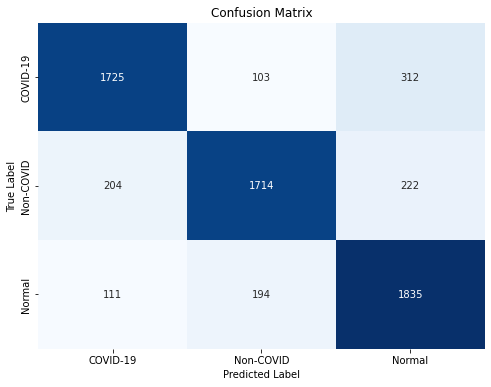

              precision    recall  f1-score   support

    COVID-19       0.95      0.92      0.93      6849
   Non-COVID       0.96      0.87      0.91      6849
      Normal       0.84      0.94      0.89      6849

    accuracy                           0.91     20547
   macro avg       0.91      0.91      0.91     20547
weighted avg       0.91      0.91      0.91     20547

              precision    recall  f1-score   support

    COVID-19       0.82      0.81      0.81      1712
   Non-COVID       0.86      0.76      0.81      1712
      Normal       0.75      0.84      0.79      1712

    accuracy                           0.80      5136
   macro avg       0.81      0.80      0.81      5136
weighted avg       0.81      0.80      0.81      5136

              precision    recall  f1-score   support

    COVID-19       0.85      0.81      0.83      2140
   Non-COVID       0.85      0.80      0.83      2140
      Normal       0.77      0.86      0.81      2140

    accuracy        

In [ ]:
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    criterion='entropy',
    min_samples_split=5,
    random_state=42
)

# Record the current time before executing the code
start_time = time.time()
# Training the classifier
rf_classifier.fit(X_train_feature_reduction, y_train)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Training Time Used: ' + str(elapsed_time) + 's')

# Calculating accuracy
accuracy = accuracy_score(y_train, y_train_pred_rf)
print("Training Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_train_pred_rf= rf_classifier.predict(X_train_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Record the current time before executing the code
start_time = time.time()
# Predicting on the val set
y_val_pred_rf = rf_classifier.predict(X_val_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time) + 's')

# Calculating accuracy
accuracy = accuracy_score(y_val, y_val_pred_rf)
print("Val Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_test_pred_rf = rf_classifier.predict(X_test_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Prediction Time Used: ' + str(elapsed_time) + 's')

# Calculating accuracy
accuracy = accuracy_score(y_test, y_test_pred_rf)
print("Test Accuracy:", accuracy)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_rf)

# Define class labels
classes = np.unique(y_test)  # Update with your class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_train, y_train_pred_rf))
print(classification_report(y_val, y_val_pred_rf))
print(classification_report(y_test, y_test_pred_rf))

[I 2024-04-12 14:52:07,023] A new study created in memory with name: no-name-4a8a3ffe-871e-4a8e-bfbc-578a6186fc8b
[I 2024-04-12 14:52:17,310] Trial 0 finished with value: 0.7815420560747663 and parameters: {'n_estimators': 50, 'max_depth': 5, 'criterion': 'gini', 'min_samples_split': 2}. Best is trial 0 with value: 0.7815420560747663.
[I 2024-04-12 14:53:21,849] Trial 1 finished with value: 0.7856308411214953 and parameters: {'n_estimators': 200, 'max_depth': 5, 'criterion': 'entropy', 'min_samples_split': 2}. Best is trial 1 with value: 0.7856308411214953.
[I 2024-04-12 14:53:53,779] Trial 2 finished with value: 0.7860202492211839 and parameters: {'n_estimators': 100, 'max_depth': 5, 'criterion': 'entropy', 'min_samples_split': 5}. Best is trial 2 with value: 0.7860202492211839.
[I 2024-04-12 14:54:25,924] Trial 3 finished with value: 0.7860202492211839 and parameters: {'n_estimators': 100, 'max_depth': 5, 'criterion': 'entropy', 'min_samples_split': 5}. Best is trial 2 with value: 0.

Optimization Time Used: 1335.9706749916077s
Training Time Used: 116.9215350151062s
Predict Time Used: 0.597538948059082
Training Time Used: -0.0003170967102050781s
Val Accuracy: 0.8115264797507789
Prediction Time Used: 1.5735626220703125e-05s
Test Accuracy: 0.8182242990654206


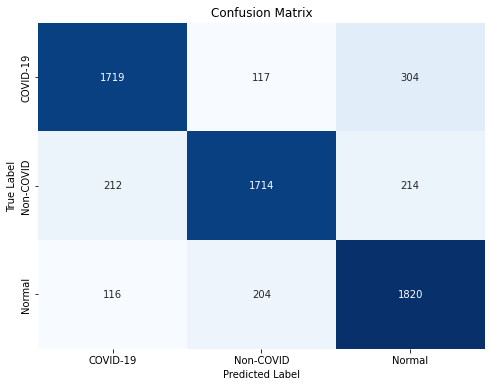

              precision    recall  f1-score   support

    COVID-19       0.84      0.80      0.82      2140
   Non-COVID       0.84      0.80      0.82      2140
      Normal       0.78      0.85      0.81      2140

    accuracy                           0.82      6420
   macro avg       0.82      0.82      0.82      6420
weighted avg       0.82      0.82      0.82      6420



In [ ]:
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 200])
    max_depth = trial.suggest_categorical('max_depth', [5, 10])
    criterion = trial.suggest_categorical('criterion', ["gini", "entropy"])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])

    # Create and train the Random Forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        criterion=criterion,
        min_samples_split=min_samples_split,
        random_state=42
    )

    model.fit(X_train_feature_reduction, y_train)

    # Calculate the accuracy on the validation set
    y_pred = model.predict(X_val_feature_reduction)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# Record the current time before executing the code
start_time = time.time()
# Define the study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Optimization Time Used: ' + str(elapsed_time)+'s')

# Get the best trial's hyperparameters
best_trial = study.best_trial
best_params = best_trial.params
rf_classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    criterion=best_params['criterion'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

# Record the current time before executing the code
start_time = time.time()
# Training the classifier
rf_classifier.fit(X_train_feature_reduction, y_train)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Training Time Used: ' + str(elapsed_time) + 's')

# Calculating accuracy
accuracy = accuracy_score(y_train, y_train_pred_rf)
print("Training Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_train_pred_rf= rf_classifier.predict(X_train_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Record the current time before executing the code
start_time = time.time()
# Predicting on the val set
y_val_pred_rf = rf_classifier.predict(X_val_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time) + 's')

# Calculating accuracy
accuracy = accuracy_score(y_val, y_val_pred_rf)
print("Val Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_test_pred_rf = rf_classifier.predict(X_test_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Prediction Time Used: ' + str(elapsed_time) + 's')

# Calculating accuracy
accuracy = accuracy_score(y_test, y_test_pred_rf)
print("Test Accuracy:", accuracy)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_rf)

# Define class labels
classes = np.unique(y_test)  # Update with your class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_train, y_train_pred_rf))
print(classification_report(y_val, y_val_pred_rf))
print(classification_report(y_test, y_test_pred_rf))

Training Accuracy: 0.9203776707061858
Predict Time Used: 0.1538708209991455s
Val Accuracy: 0.8115264797507789
Prediction Time Used: 0.20141386985778809s
Test Accuracy: 0.8182242990654206


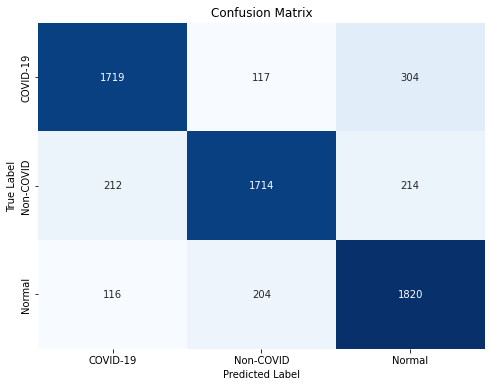

              precision    recall  f1-score   support

    COVID-19       0.95      0.93      0.94      6849
   Non-COVID       0.97      0.87      0.92      6849
      Normal       0.85      0.96      0.90      6849

    accuracy                           0.92     20547
   macro avg       0.93      0.92      0.92     20547
weighted avg       0.93      0.92      0.92     20547

              precision    recall  f1-score   support

    COVID-19       0.82      0.82      0.82      1712
   Non-COVID       0.85      0.77      0.81      1712
      Normal       0.77      0.84      0.80      1712

    accuracy                           0.81      5136
   macro avg       0.81      0.81      0.81      5136
weighted avg       0.81      0.81      0.81      5136

              precision    recall  f1-score   support

    COVID-19       0.84      0.80      0.82      2140
   Non-COVID       0.84      0.80      0.82      2140
      Normal       0.78      0.85      0.81      2140

    accuracy        

In [ ]:
import joblib

In [ ]:
# Save the model to a file
filename = 'rf_90.pkl'
joblib.dump(rf_classifier, filename)


['rf_90.pkl']

# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1410.822206, rho = -0.184865
nSV = 2000, nBSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1554.229205, rho = -0.099198
nSV = 2000, nBSV = 2000
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -1622.724075, rho = -0.095780
nSV = 2000, nBSV = 2000
Total nSV = 5016
Training Time Used: 14.044706583023071


/Users/wudiqing/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predict Time Used: 31.367276191711426
Training Accuracy: 0.9609188689346376
Prediction Time Used: 7.920851945877075
Val Accuracy: 0.8691588785046729
Prediction Time Used: 9.923810243606567
Test Accuracy: 0.8808411214953271


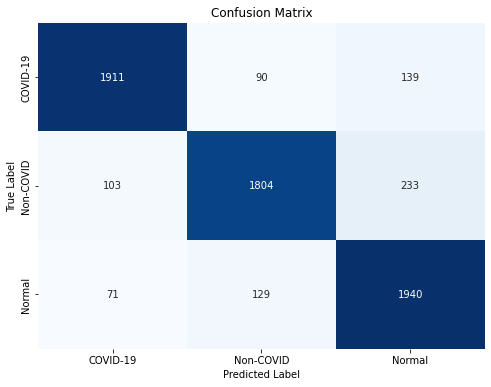

              precision    recall  f1-score   support

    COVID-19       0.98      0.99      0.99      6849
   Non-COVID       0.97      0.92      0.95      6849
      Normal       0.93      0.97      0.95      6849

    accuracy                           0.96     20547
   macro avg       0.96      0.96      0.96     20547
weighted avg       0.96      0.96      0.96     20547

              precision    recall  f1-score   support

    COVID-19       0.92      0.91      0.92      1712
   Non-COVID       0.88      0.81      0.85      1712
      Normal       0.81      0.88      0.84      1712

    accuracy                           0.87      5136
   macro avg       0.87      0.87      0.87      5136
weighted avg       0.87      0.87      0.87      5136

              precision    recall  f1-score   support

    COVID-19       0.92      0.89      0.90      2140
   Non-COVID       0.89      0.84      0.87      2140
      Normal       0.84      0.91      0.87      2140

    accuracy        

In [ ]:
svm_classifier = SVC(C=1.0, kernel='rbf', max_iter = 1000, random_state=42, verbose=2)

# Record the current time before executing the code
start_time = time.time()
# Training the classifier
svm_classifier.fit(X_train_feature_reduction, y_train)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Training Time Used: ' + str(elapsed_time))


# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_train_pred_svm = svm_classifier.predict(X_train_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_train, y_train_pred_svm)
print("Training Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the val set
y_val_pred_svm = svm_classifier.predict(X_val_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Prediction Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_val, y_val_pred_svm)
print("Val Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_test_pred_svm = svm_classifier.predict(X_test_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Prediction Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_test, y_test_pred_svm)
print("Test Accuracy:", accuracy)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_svm)

# Define class labels
classes = np.unique(y_test)  # Update with your class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_train, y_train_pred_svm))
print(classification_report(y_val, y_val_pred_svm))
print(classification_report(y_test, y_test_pred_svm))

/Users/wudiqing/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Time Used: 15.11056399345398
Predict Time Used: 19.103893041610718
Training Accuracy: 0.7039470482308853
Prediction Time Used: 4.795391082763672
Val Accuracy: 0.7098909657320872
Prediction Time Used: 6.012643814086914
Test Accuracy: 0.6845794392523364


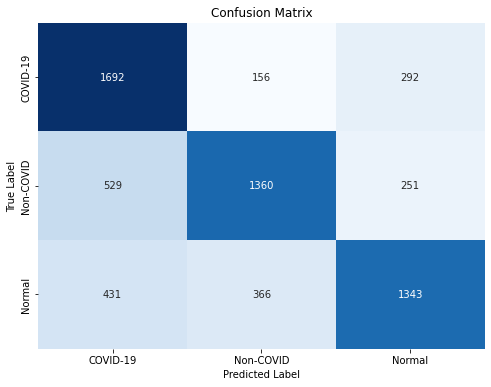

              precision    recall  f1-score   support

    COVID-19       0.68      0.83      0.75      6849
   Non-COVID       0.72      0.62      0.66      6849
      Normal       0.72      0.66      0.69      6849

    accuracy                           0.70     20547
   macro avg       0.71      0.70      0.70     20547
weighted avg       0.71      0.70      0.70     20547

              precision    recall  f1-score   support

    COVID-19       0.68      0.81      0.74      1712
   Non-COVID       0.73      0.64      0.68      1712
      Normal       0.74      0.68      0.71      1712

    accuracy                           0.71      5136
   macro avg       0.71      0.71      0.71      5136
weighted avg       0.71      0.71      0.71      5136

              precision    recall  f1-score   support

    COVID-19       0.64      0.79      0.71      2140
   Non-COVID       0.72      0.64      0.68      2140
      Normal       0.71      0.63      0.67      2140

    accuracy        

In [ ]:
# Define objective function for optimization
def objective(trial):
    # Define hyperparameters to be tuned
    C = trial.suggest_categorical('C', [1e-4, 1, 1e2])
    kernel = trial.suggest_categorical('kernel', ['linear', 'sigmoid', 'rbf'])
    gamma = trial.suggest_categorical('gamma', [1e-5, 1e-1, 10]) if kernel in ['sigmoid', 'rbf'] else 'scale'

    # Instantiate SVM model with hyperparameters
    model = SVC(C=C, kernel=kernel, gamma=gamma, max_iter = 1000, random_state=42, verbose=2)

    # Train model
    model.fit(X_train_feature_reduction, y_train)

    # Calculate the accuracy on the validation set
    y_pred = model.predict(X_val_feature_reduction)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy
# Record the current time before executing the code
start_time = time.time()
# Define the study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Optimization Time Used: ' + str(elapsed_time))

# Get the best trial's hyperparameters
best_trial = study.best_trial
best_params = best_trial.params
svm_classifier = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],ex
    gamma=best_params['gamma'],
    max_iter = 1000,
    random_state=42
)

# Record the current time before executing the code
start_time = time.time()
# Training the classifier
svm_classifier.fit(X_train_feature_reduction, y_train)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Training Time Used: ' + str(elapsed_time))


# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_train_pred_svm = svm_classifier.predict(X_train_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_train, y_train_pred_svm)
print("Training Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the val set
y_val_pred_svm = svm_classifier.predict(X_val_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Prediction Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_val, y_val_pred_svm)
print("Val Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_test_pred_svm = svm_classifier.predict(X_test_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Prediction Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_test, y_test_pred_svm)
print("Test Accuracy:", accuracy)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_svm)

# Define class labels
classes = np.unique(y_test)  # Update with your class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_train, y_train_pred_svm))
print(classification_report(y_val, y_val_pred_svm))
print(classification_report(y_test, y_test_pred_svm))

In [ ]:
# Save the model to a file
filename = 'svm_90.pkl'
joblib.dump(svm_classifier, filename)

['svm_90.pkl']

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Training Time Used: 8.55466103553772
Predict Time Used: 0.013206243515014648
Training Accuracy: 0.8788630943690077
Predict Time Used: 0.005229949951171875
Val Accuracy: 0.8666277258566978
Predict Time Used: 0.00385284423828125
Test Accuracy: 0.8814641744548286


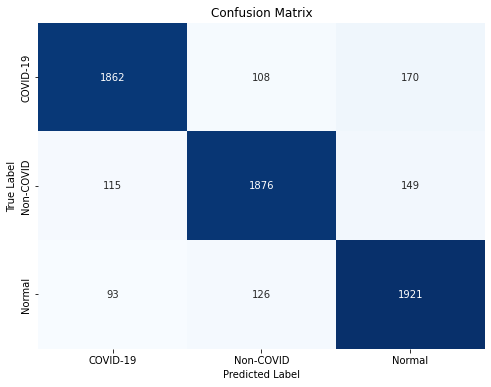

              precision    recall  f1-score   support

    COVID-19       0.91      0.90      0.91      6849
   Non-COVID       0.89      0.84      0.87      6849
      Normal       0.84      0.89      0.86      6849

    accuracy                           0.88     20547
   macro avg       0.88      0.88      0.88     20547
weighted avg       0.88      0.88      0.88     20547

              precision    recall  f1-score   support

    COVID-19       0.90      0.88      0.89      1712
   Non-COVID       0.88      0.84      0.86      1712
      Normal       0.83      0.87      0.85      1712

    accuracy                           0.87      5136
   macro avg       0.87      0.87      0.87      5136
weighted avg       0.87      0.87      0.87      5136

              precision    recall  f1-score   support

    COVID-19       0.90      0.87      0.88      2140
   Non-COVID       0.89      0.88      0.88      2140
      Normal       0.86      0.90      0.88      2140

    accuracy        

In [ ]:
logistic_model = LogisticRegression(
    C=0.1,
    penalty='l1',
    solver='liblinear',
    random_state=42
)

# Record the current time before executing the code
start_time = time.time()
# Training the model
logistic_model.fit(X_train_feature_reduction, y_train)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Training Time Used: ' + str(elapsed_time))

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_train_pred_logistic = logistic_model.predict(X_train_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_train, y_train_pred_logistic)
print("Training Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the val set
y_val_pred_logistic = logistic_model.predict(X_val_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_val, y_val_pred_logistic)
print("Val Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_test_pred_logistic = logistic_model.predict(X_test_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_test, y_test_pred_logistic)
print("Test Accuracy:", accuracy)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_logistic)

# Define class labels
classes = np.unique(y_test)  # Update with your class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print(classification_report(y_train, y_train_pred_logistic))
print(classification_report(y_val, y_val_pred_logistic))
print(classification_report(y_test, y_test_pred_logistic))

In [ ]:
def objective(trial):
    # Define the hyperparameters to tune
    #C = trial.suggest_categorical('C', [1e-2]+np.linspace(1e-1, 1e0, num=2).tolist()+[1e1])
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    # Create and train the Logistic Regression model
    model = LogisticRegression(C=C, penalty=penalty, solver='liblinear', random_state=42)
    model.fit(X_train_feature_reduction, y_train)

    # Calculate the accuracy on the validation set
    y_pred = model.predict(X_val_feature_reduction)
    accuracy = accuracy_score(y_val, y_pred)
    del model
    return accuracy

# Record the current time before executing the code
start_time = time.time()
# Define the study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Optimization Time Used: ' + str(elapsed_time))

# Get the best trial's hyperparameters
best_trial = study.best_trial
best_params = best_trial.params
logistic_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='liblinear',
    random_state=42
)

# Record the current time before executing the code
start_time = time.time()
# Training the model
logistic_model.fit(X_train_feature_reduction, y_train)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Training Time Used: ' + str(elapsed_time))

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_train_pred_logistic = logistic_model.predict(X_train_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_train, y_train_pred_logistic)
print("Training Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the val set
y_val_pred_logistic = logistic_model.predict(X_val_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_val, y_val_pred_logistic)
print("Val Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_test_pred_logistic = logistic_model.predict(X_test_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_test, y_test_pred_logistic)
print("Test Accuracy:", accuracy)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_logistic)

# Define class labels
classes = np.unique(y_test)  # Update with your class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print(classification_report(y_train, y_train_pred_logistic))
print(classification_report(y_val, y_val_pred_logistic))
print(classification_report(y_test, y_test_pred_logistic))


In [ ]:
# Save the model to a file
filename = 'logistic_90.pkl'
joblib.dump(logistic_model, filename)

# Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

      Iter       Train Loss   Remaining Time 
         1           1.0377           18.34m
         2           0.9873           18.21m
         3           0.9441           17.98m
         4           0.9075           17.80m
         5           0.8765           17.63m
         6           0.8487           17.42m
         7           0.8243           17.25m
         8           0.8018           17.06m
         9           0.7814           16.87m
        10           0.7641           16.69m
        11           0.7477           16.53m
        12           0.7312           16.38m
        13           0.7180           16.20m
        14           0.7045           16.01m
        15           0.6931           15.82m
        16           0.6819           15.62m
        17           0.6711           15.44m
        18           0.6616           15.25m
        19           0.6528           15.07m
        20           0.6445           14.88m
        21           0.6357           14.69m
        2

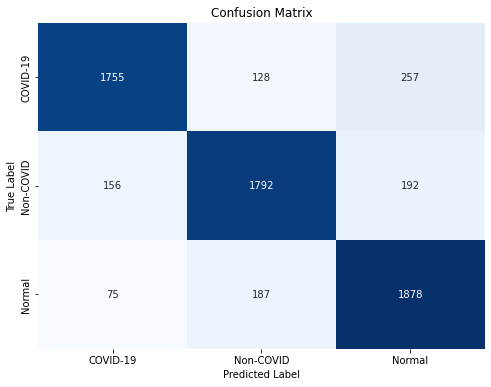

              precision    recall  f1-score   support

    COVID-19       0.89      0.87      0.88      6849
   Non-COVID       0.88      0.82      0.85      6849
      Normal       0.81      0.88      0.85      6849

    accuracy                           0.86     20547
   macro avg       0.86      0.86      0.86     20547
weighted avg       0.86      0.86      0.86     20547

              precision    recall  f1-score   support

    COVID-19       0.87      0.85      0.86      1712
   Non-COVID       0.86      0.82      0.84      1712
      Normal       0.80      0.86      0.83      1712

    accuracy                           0.84      5136
   macro avg       0.84      0.84      0.84      5136
weighted avg       0.84      0.84      0.84      5136

              precision    recall  f1-score   support

    COVID-19       0.88      0.82      0.85      2140
   Non-COVID       0.85      0.84      0.84      2140
      Normal       0.81      0.88      0.84      2140

    accuracy        

In [ ]:
gbm_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=1.0,
                                   random_state=42,verbose=2)

# Record the current time before executing the code
start_time = time.time()
# Training the model
gbm_model.fit(X_train_feature_reduction, y_train)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Training Time Used: ' + str(elapsed_time))

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_train_pred_gbm = gbm_model.predict(X_train_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_train, y_train_pred_gbm)
print("Training Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the val set
y_val_pred_gbm = gbm_model.predict(X_val_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_val, y_val_pred_gbm)
print("Val Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_test_pred_gbm = gbm_model.predict(X_test_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_test, y_test_pred_gbm)
print("Test Accuracy:", accuracy)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_gbm)

# Define class labels
classes = np.unique(y_test)  # Update with your class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_train, y_train_pred_gbm))
print(classification_report(y_val, y_val_pred_gbm))
print(classification_report(y_test, y_test_pred_gbm))

In [ ]:
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 1.0]),
    }

    # Train the GBM model
    model = GradientBoostingClassifier(**params)
    model.fit(X_train_feature_reduction, y_train)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val_feature_reduction)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# Record the current time before executing the code
start_time = time.time()
# Create the study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Optimization Time Used: ' + str(elapsed_time))

# Get the best hyperparameters and best accuracy
best_trial = study.best_trial
best_params = best_trial.params
best_accuracy = best_trial.value

# Get the best trial's hyperparameters
best_trial = study.best_trial
best_params = best_trial.params
logistic_model = GradientBoostingClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    subsample = best_params['subsample'],
    random_state=42,
    verbose=2
)

# Record the current time before executing the code
start_time = time.time()
# Training the model
gbm_model.fit(X_train_feature_reduction, y_train)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Training Time Used: ' + str(elapsed_time))

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_train_pred_gbm = gbm_model.predict(X_train_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_train, y_train_pred_gbm)
print("Training Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the val set
y_val_pred_gbm = gbm_model.predict(X_val_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_val, y_val_pred_gbm)
print("Val Accuracy:", accuracy)

# Record the current time before executing the code
start_time = time.time()
# Predicting on the test set
y_test_pred_gbm = gbm_model.predict(X_test_feature_reduction)
# Record the current time after executing the code
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print('Predict Time Used: ' + str(elapsed_time))

# Calculating accuracy
accuracy = accuracy_score(y_test, y_test_pred_gbm)
print("Test Accuracy:", accuracy)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_gbm)

# Define class labels
classes = np.unique(y_test)  # Update with your class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_train, y_train_pred_gbm))
print(classification_report(y_val, y_val_pred_gbm))
print(classification_report(y_test, y_test_pred_gbm))

[I 2024-04-12 15:33:20,696] A new study created in memory with name: no-name-b2ee099c-b3c2-4138-970c-411e7bbc4fb4
[I 2024-04-12 16:42:26,595] Trial 0 finished with value: 0.7776479750778816 and parameters: {'learning_rate': 0.01, 'n_estimators': 200, 'subsample': 1.0}. Best is trial 0 with value: 0.7776479750778816.
[I 2024-04-12 17:17:02,058] Trial 1 finished with value: 0.847936137071651 and parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0}. Best is trial 1 with value: 0.847936137071651.
[W 2024-04-12 17:34:21,277] Trial 2 failed with parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/wudiqing/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/53/snbtvny15m18cczpbnzn28880000gn/T/ipykernel_28917/734785103.py", line 11, in objective
    model.fit

KeyboardInterrupt: 

In [ ]:
# Save the model to a file
filename = 'gbm_90.pkl'
joblib.dump(gbm_model, filename)

# Feed Forward Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Define the number of classes
num_classes = 3

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_feature_reduction.shape[1],)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train_feature_reduction, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_train_feature_reduction, y_train)
print(f"Training Accuracy: {accuracy}")

In [ ]:
# Evaluating the model on val data
loss, accuracy = model.evaluate(X_val_feature_reduction, y_val)
print("Valuation Accuracy:", accuracy)

In [ ]:
# Evaluating the model on test data
loss, accuracy = model.evaluate(X_test_feature_reduction, y_test)
print("Test Accuracy:", accuracy)